## [Markov switching autoregression models](https://github.com/ChadFulton/tsa-notebooks/edit/master/markov_autoregression.ipynb)
#### Merged with [statsmodel sample](https://www.statsmodels.org/stable/examples/notebooks/generated/markov_autoregression.html)

This notebook provides an example of the use of Markov switching models in Statsmodels to replicate a number of results presented in Kim and Nelson (1999). It applies the Hamilton (1989) filter the Kim (1994) smoother.

This is tested against the Markov-switching models from E-views 8, which can be found at http://www.eviews.com/EViews8/ev8ecswitch_n.html#MarkovAR or the Markov-switching models of Stata 14 which can be found at http://www.stata.com/manuals14/tsmswitch.pdf.

In [ ]:
%pip install seaborn pytest pandas_datareader

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn

# NBER recessions
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

### Hamilton (1989) switching model of GNP

This replicates Hamilton's (1989) seminal paper introducing Markov-switching models. The model is an autoregressive model of order 4 in which the mean of the process switches between two regimes. It can be written:

$$
y_t = \mu_{S_t} + \phi_1 (y_{t-1} - \mu_{S_{t-1}}) + \phi_2 (y_{t-2} - \mu_{S_{t-2}}) + \phi_3 (y_{t-3} - \mu_{S_{t-3}}) + \phi_4 (y_{t-4} - \mu_{S_{t-4}}) + \varepsilon_t
$$

Each period, the regime transitions according to the following matrix of transition probabilities:

$$ P(S_t = s_t | S_{t-1} = s_{t-1}) =
\begin{bmatrix}
p_{00} & p_{10} \\
p_{01} & p_{11}
\end{bmatrix}
$$

where $p_{ij}$ is the probability of transitioning *from* regime $i$, *to* regime $j$.

The model class is `MarkovAutoregression` in the time-series part of `Statsmodels`. In order to create the model, we must specify the number of regimes with `k_regimes=2`, and the order of the autoregression with `order=4`. The default model also includes switching autoregressive coefficients, so here we also need to specify `switching_ar=False` to avoid that.

After creation, the model is `fit` via maximum likelihood estimation. Under the hood, good starting parameters are found using a number of steps of the expectation maximization (EM) algorithm, and a quasi-Newton (BFGS) algorithm is applied to quickly find the maximum.

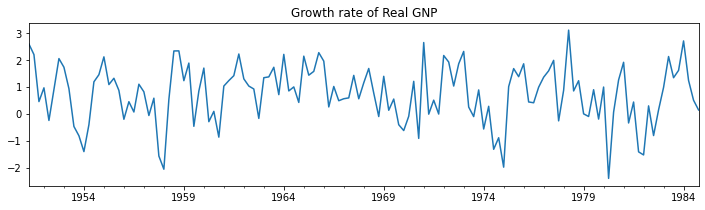

In [7]:
# Get the RGNP data to replicate Hamilton
from statsmodels.tsa.regime_switching.tests.test_markov_autoregression import rgnp
dta_hamilton = pd.Series(rgnp, index=pd.date_range('1951-04-01', '1984-10-01', freq='QS'))

# Plot the data
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [14]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Wed, 02 Nov 2022   AIC                            380.527
Time:                          23:04:38   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

We plot the filtered and smoothed probabilities of a recession. Filtered refers to an estimate of the probability at time $t$ based on data up to and including time $t$ (but excluding time $t+1, ..., T$). Smoothed refers to an estimate of the probability at time $t$ using all the data in the sample.

For reference, the shaded periods represent the NBER recessions.

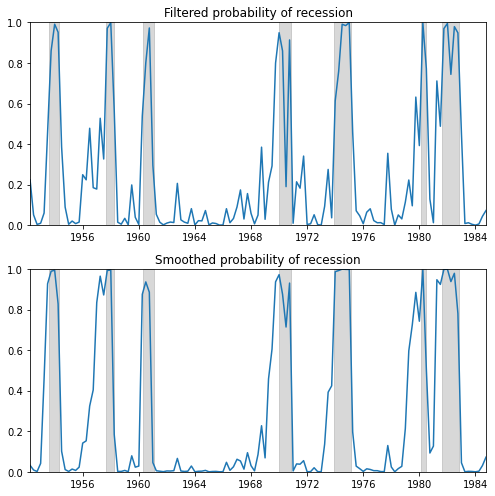

In [9]:
fig, axes = plt.subplots(2, figsize=(7,7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
ax.set(xlim=(dta_hamilton.index[4], dta_hamilton.index[-1]), ylim=(0, 1),
       title='Filtered probability of recession')

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
ax.set(xlim=(dta_hamilton.index[4], dta_hamilton.index[-1]), ylim=(0, 1),
       title='Smoothed probability of recession')

fig.tight_layout()

From the estimated transition matrix we can calculate the expected duration of a recession versus an expansion.

In [10]:
print(res_hamilton.expected_durations)

[ 4.07604794 10.42589257]


In this case, it is expected that a recession will last about one year (4 quarters) and an expansion about two and a half years.

### Kim, Nelson, and Startz (1998) Three-state Variance Switching

This model demonstrates estimation with regime heteroskedasticity (switching of variances) and no mean effect. The dataset can be reached at http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn.

The model in question is:

$$
\begin{align}
y_t & = \varepsilon_t \\
\varepsilon_t & \sim N(0, \sigma_{S_t}^2)
\end{align}
$$

Since there is no autoregressive component, this model can be fit using the `MarkovRegression` class. Since there is no mean effect, we specify `trend='nc'`. There are hypotheized to be three regimes for the switching variances, so we specify `k_regimes=3` and `switching_variance=True` (by default, the variance is assumed to be the same across regimes).

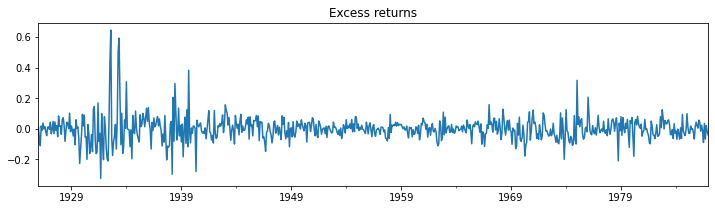

In [17]:
import requests
from io import BytesIO

ew_excs = requests.get("http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn").content
raw = pd.read_table(BytesIO(ew_excs), header=None, skipfooter=1, engine="python")
raw.index = pd.date_range("1926-01-01", "1995-12-01", freq="MS")

dta_kns = raw.loc[:"1986"] - raw.loc[:"1986"].mean()

# Plot the dataset
dta_kns[0].plot(title="Excess returns", figsize=(12, 3))

# Fit the model
mod_kns = sm.tsa.MarkovRegression(
    dta_kns, k_regimes=3, trend="n", switching_variance=True
)
res_kns = mod_kns.fit()

In [18]:
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      0   No. Observations:                  732
Model:               MarkovRegression   Log Likelihood                1001.895
Date:                Wed, 02 Nov 2022   AIC                          -1985.790
Time:                        23:06:06   BIC                          -1944.428
Sample:                    01-01-1926   HQIC                         -1969.834
                         - 12-01-1986                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      7.136      0.000       0.001       0.002
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0040      0.000      8.489      0.000       0.003       0.005
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0311      0.006      5.461      0.000       0.020       0.042
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9747      0.000   7857.416      0.000       0.974       0.975
p[1->0]        0.0195      0.010      1.949      0.051      -0.000       0.039
p[2->0]     2.354e-08        nan        nan        nan         nan         nan
p[0->1]        0.0253   3.97e-05    637.835      0.000       0.025       0.025
p[1->1]        0.9688      0.013     75.528      0.000       0.944       0.994
p[2->1]        0.0493      0.032      1.551      0.121      -0.013       0.112
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Below we plot the probabilities of being in each of the regimes; only in a few periods is a high-variance regime probable.

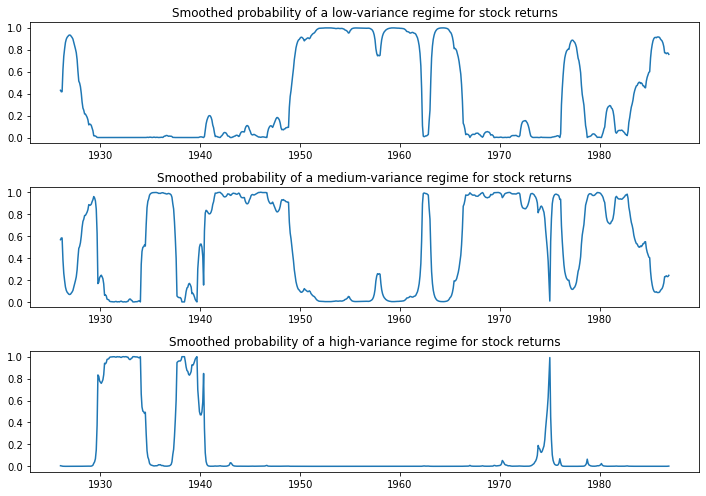

In [19]:
fig, axes = plt.subplots(3, figsize=(10,7))

ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')

ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')

ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')

fig.tight_layout()

### Filardo (1994) Time-Varying Transition Probabilities

This model demonstrates estimation with time-varying transition probabilities. The dataset can be reached at http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn.

In the above models we have assumed that the transition probabilities are constant across time. Here we allow the probabilities to change with the state of the economy. Otherwise, the model is the same Markov autoregression of Hamilton (1989).

Each period, the regime now transitions according to the following matrix of time-varying transition probabilities:

$$ P(S_t = s_t | S_{t-1} = s_{t-1}) =
\begin{bmatrix}
p_{00,t} & p_{10,t} \\
p_{01,t} & p_{11,t}
\end{bmatrix}
$$

where $p_{ij,t}$ is the probability of transitioning *from* regime $i$, *to* regime $j$ in period $t$, and is defined to be:

$$
p_{ij,t} = \frac{\exp\{ x_{t-1}' \beta_{ij} \}}{1 + \exp\{ x_{t-1}' \beta_{ij} \}}
$$

Instead of estimating the transition probabilities as part of maximum likelihood, the regression coefficients $\beta_{ij}$ are estimated. These coefficients relate the transition probabilities to a vector of pre-determined or exogenous regressors $x_{t-1}$.

<AxesSubplot:title={'center':'Leading indicator'}>

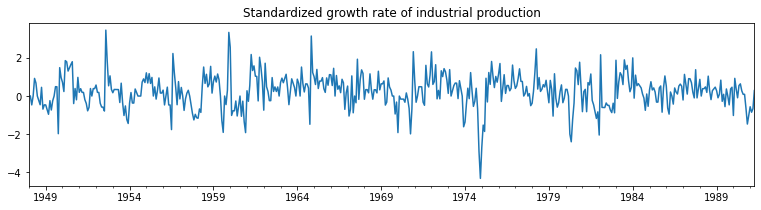

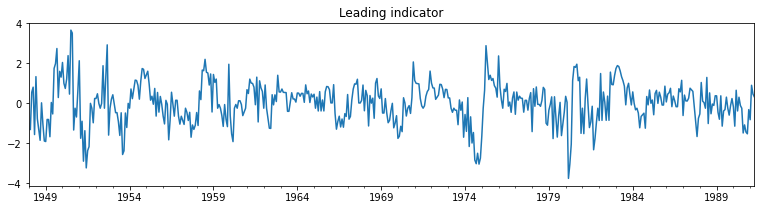

In [21]:
filardo = requests.get("http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn").content
dta_filardo = pd.read_table(
    BytesIO(filardo), sep=" +", header=None, skipfooter=1, engine="python"
)
dta_filardo.columns = ["month", "ip", "leading"]
dta_filardo.index = pd.date_range("1948-01-01", "1991-04-01", freq="MS")

dta_filardo["dlip"] = np.log(dta_filardo["ip"]).diff() * 100
# Deflated pre-1960 observations by ratio of std. devs.
# See hmt_tvp.opt or Filardo (1994) p. 302
std_ratio = (
    dta_filardo["dlip"]["1960-01-01":].std() / dta_filardo["dlip"][:"1959-12-01"].std()
)
dta_filardo["dlip"][:"1959-12-01"] = dta_filardo["dlip"][:"1959-12-01"] * std_ratio

dta_filardo["dlleading"] = np.log(dta_filardo["leading"]).diff() * 100
dta_filardo["dmdlleading"] = dta_filardo["dlleading"] - dta_filardo["dlleading"].mean()

# Plot the data
dta_filardo["dlip"].plot(
    title="Standardized growth rate of industrial production", figsize=(13, 3)
)
plt.figure()
dta_filardo["dmdlleading"].plot(title="Leading indicator", figsize=(13, 3))

The time-varying transition probabilities are specified by the `exog_tvtp` parameter.

Here we demonstrate another feature of model fitting - the use of a random search for MLE starting parameters. Because Markov switching models are often characterized by many local maxima of the likelihood function, performing an initial optimization step can be helpful to find the best parameters.

Below, we specify that 20 random perturbations from the starting parameter vector are examined and the best one used as the actual starting parameters. Because of the random nature of the search, we seed the random number generator beforehand to allow replication of the result.

In [23]:
mod_filardo = sm.tsa.MarkovAutoregression(
    dta_filardo.iloc[2:]["dlip"],
    k_regimes=2,
    order=4,
    switching_ar=False,
    exog_tvtp=sm.add_constant(dta_filardo.iloc[1:-1]["dmdlleading"]),
)

np.random.seed(12345)
res_filardo = mod_filardo.fit(search_reps=20)

In [24]:
res_filardo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     dlip   No. Observations:                  514
Model:             MarkovAutoregression   Log Likelihood                -586.572
Date:                  Wed, 02 Nov 2022   AIC                           1195.144
Time:                          23:07:11   BIC                           1241.808
Sample:                      03-01-1948   HQIC                          1213.433
                           - 04-01-1991                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8659      0.153     -5.658      0.000      -1.166      -0.566
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5173      0.077      6.706      0.000       0.366       0.668
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4844      0.037     13.172      0.000       0.412       0.556
ar.L1          0.1895      0.050      3.761      0.000       0.091       0.288
ar.L2          0.0793      0.051      1.552      0.121      -0.021       0.180
ar.L3          0.1109      0.052      2.136      0.033       0.009       0.213
ar.L4          0.1223      0.051      2.418      0.016       0.023       0.221
                           Regime transition parameters                          
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
p[0->0].tvtp0     1.6494      0.446      3.702      0.000       0.776       2.523
p[1->0].tvtp0    -4.3595      0.747     -5.833      0.000      -5.824      -2.895
p[0->0].tvtp1    -0.9945      0.566     -1.758      0.079      -2.103       0.114
p[1->0].tvtp1    -1.7702      0.508     -3.484      0.000      -2.766      -0.775
=================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Below we plot the smoothed probability of the economy operating in a low-production state, and again include the NBER recessions for comparison.

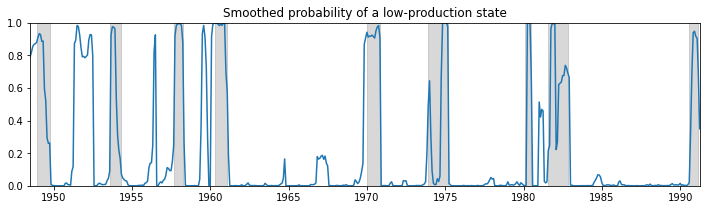

In [25]:
fig, ax = plt.subplots(figsize=(12,3))

ax.plot(res_filardo.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
ax.set(xlim=(dta_filardo.index[6], dta_filardo.index[-1]), ylim=(0, 1),
       title='Smoothed probability of a low-production state');

Using the time-varying transition probabilities, we can see how the expected duration of a low-production state changes over time:


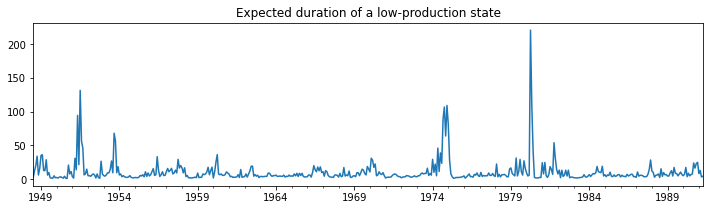

In [26]:
res_filardo.expected_durations[0].plot(
    title='Expected duration of a low-production state', figsize=(12,3));

During recessions, the expected duration of a low-production state is much higher than in an expansion.